# Download Data

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul 29 03:21:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tr_path = "covid.train.csv"
tt_path = "covid.test.csv"

!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 128MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 42.1MB/s]


# Import Some Package

In [4]:
#Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#Data Preprocessing
import numpy as np
import csv
import os

#For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#myseed = 42069
myseed = 666

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(myseed)

# Some Utilities

In [5]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

# Preprocess

**Dataset**

In [6]:
#import pandas as pd

#df = pd.read_csv('covid.train.csv').iloc[:,1:]
#print(df.columns)
#print(df.columns[df.corr().iloc[:,-1] > 0.5])


class COVID19Dataset(Dataset):
  #Dataset for loading and preprocessing the COVID19 dataset
  def __init__(self, path, mode = 'train', target_only = False):
    self.mode = mode

    #Read data into numpy arrays
    with open(path, 'r') as fp:
      data = list(csv.reader(fp))
      data = np.array(data[1:])[:, 1:].astype(float)
    
    if not target_only:
      feats = list(range(93))
    else:
      feats = [40, 41, 42, 43, 56, 57, 58, 59, 60, 61, 74, 75, 76, 77, 78, 79, 91, 92]
      #feats = [40, 41, 42, 43, 47, 51, 56, 57, 58, 59, 60, 61, 65, 69, 74, 75, 76, 77, 78, 79, 83, 87, 92]
    if mode == 'test':
      data = data[:, feats]
      self.data = torch.FloatTensor(data)
    else:
      target = data[:, -1]
      data = data[:, feats]

      if mode == 'train':
        indices = [i for i in range(len(data)) if i % 10 != 0]
      elif mode == 'dev':
        indices = [i for i in range(len(data)) if i % 10 == 0]
      
      self.data = torch.FloatTensor(data[indices])
      self.target = torch.FloatTensor(target[indices])

    #Normalize features (you may remove this part to see what will happen)
    #Normal distribution
    self.data[:, 40:] = \
      (self.data[:, 40:] - self.data[:, 40:].mean(dim = 0, keepdim = True))\
      / self.data[:, 40:].std(dim = 0, keepdim = True) 

    self.dim = self.data.shape[1]
    print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'.format(mode, len(self.data), self.dim))
  def __getitem__(self, index):
    #Returns one sample at a time
    if self.mode in ['train', 'dev']:
      return self.data[index], self.target[index]
    else:
      return self.data[index]
  def __len__(self):
    return len(self.data)



**DataLoader**

In [7]:
def prep_dataloader(path, mode, batch_size, n_jobs = 0, target_only = False):
  #Generates a dataset, then is put into a dataloader
  dataset = COVID19Dataset(path, mode = mode, target_only = target_only)
  dataloader = DataLoader(
      dataset,batch_size,shuffle = (mode == 'train'), drop_last = False,
      num_workers = n_jobs, pin_memory = True
  )
  return dataloader

**Deep Neural Network**

In [8]:
class NeuralNet(nn.Module):
  #a simple fully-connected deep neural network
  def __init__(self, input_dim):
    super(NeuralNet, self).__init__()

    self.net = nn.Sequential(
        nn.Linear(input_dim, 16),
        nn.ReLU(),
        nn.Linear(16, 64),
        nn.ReLU(),
        nn.Linear(64, 16),
        nn.ReLU(),
        nn.Linear(16, 1)
    )

    self.criterion = nn.MSELoss(reduction = 'mean')
  def forward(self, x):
    return self.net(x).squeeze(1)
  def cal_loss(self, pred, target):
    L1_norm = 0.001 * sum(p.abs().sum() for p in self.net.parameters())
    L2_norm = 0
    for param in model.parameters():
      L2_norm += torch.sum(torch.square(param))
    
    return self.criterion(pred, target) + 0.00005 * L2_norm

# Train/Dev/Test

**Training**

In [9]:
def train(tr_set, dv_set, model, config, device):
  #DNN training
  n_epochs = config['n_epochs']

  optimizer = getattr(torch.optim, config['optimizer'])(
      model.parameters(), **config['optim_hparas'])
  
  #Learning rate scheduler
  lambdal = lambda epoch: config['lambda'] ** epoch
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambdal)

  min_mse = 1000
  loss_record = {'train': [], 'dev': []}
  early_stop_cnt = 0
  epoch = 0
  while epoch < n_epochs:
    model.train()
    for x, y in tr_set:
      optimizer.zero_grad()
      x, y = x.to(device),y.to(device)
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)
      mse_loss.backward()
      optimizer.step()
      loss_record['train'].append(mse_loss.detach().cpu().item())
    
    #schedule learning rate
    scheduler.step()
    dev_mse = dev(dv_set, model, device)
    if dev_mse < min_mse:
      min_mse = dev_mse
      print('Saving model (epochs = {:4d}, loss = {:.4f})'.format(epoch + 1,min_mse))
      torch.save(model.state_dict(), config['save_path'])
      early_stop_cnt = 0
    else:
      early_stop_cnt += 1
    epoch += 1
    loss_record['dev'].append(dev_mse)
    if early_stop_cnt > config['early_stop']:
      break
  print('Finish training after {} epochs'.format(epoch))
  return min_mse, loss_record


**Validation**

In [10]:
def dev(dv_set, model, device):
  model.eval()
  total_loss = 0
  for x, y in dv_set:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)
    total_loss += mse_loss.detach().cpu().item() * len(x)
  total_loss = total_loss / len(dv_set.dataset)
  return total_loss

**Testing**

In [11]:
def test(tt_set, model, device):
  model.eval()
  preds = []
  for x in tt_set:
    x = x.to(device)
    with torch.no_grad():
      pred = model(x)
      preds.append(pred.detach().cpu())
  preds = torch.cat(preds, dim = 0).numpy()
  return preds

**Setup Hyper-parameters**

In [17]:
device = get_device()
os.makedirs('models', exist_ok = True)
target_only = True

config = {
    'n_epochs': 3000,
    'batch_size': 64,
    'optimizer': 'Adam',
    'optim_hparas': {
        'lr': 0.01,
        #'weight_decay': 0.005
        #'momentum': 0.3
    },
    'lambda': 0.996,
    'early_stop': 200,
    'save_path': 'models/model.pth'
}

**Load data and model**

In [18]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 18)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 18)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 18)


In [19]:
model = NeuralNet(tr_set.dataset.dim).to(device)

**Start Training**

In [20]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epochs =    1, loss = 8.5279)
Saving model (epochs =    2, loss = 4.2632)
Saving model (epochs =    3, loss = 2.5706)
Saving model (epochs =    4, loss = 1.6102)
Saving model (epochs =    6, loss = 1.5810)
Saving model (epochs =    7, loss = 1.2834)
Saving model (epochs =   13, loss = 1.1945)
Saving model (epochs =   17, loss = 1.1251)
Saving model (epochs =   19, loss = 1.0915)
Saving model (epochs =   20, loss = 1.0788)
Saving model (epochs =   25, loss = 1.0773)
Saving model (epochs =   27, loss = 1.0278)
Saving model (epochs =   31, loss = 1.0211)
Saving model (epochs =   33, loss = 1.0036)
Saving model (epochs =   34, loss = 0.9900)
Saving model (epochs =   36, loss = 0.9721)
Saving model (epochs =   38, loss = 0.9521)
Saving model (epochs =   42, loss = 0.9129)
Saving model (epochs =   49, loss = 0.9008)
Saving model (epochs =   53, loss = 0.8935)
Saving model (epochs =   54, loss = 0.8783)
Saving model (epochs =   57, loss = 0.8694)
Saving model (epochs =   69, los

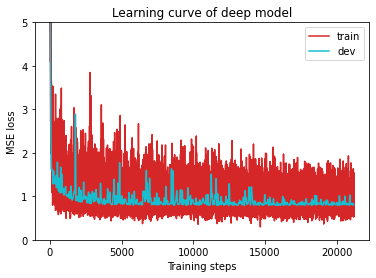

In [21]:
plot_learning_curve(model_loss_record, title = 'deep model')

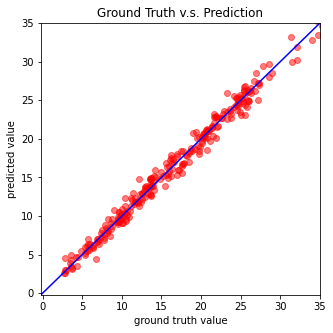

In [22]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location = 'cpu')
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)

**Stacking**

In [24]:
import xgboost as xg
from sklearn.svm import SVR
import pandas as pd

# training & testing set
df_train = pd.read_csv('covid.train.csv').iloc[:,1:]
df_test = pd.read_csv('covid.test.csv').iloc[:,1:]
  
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',gamma=0.5,reg_alpha=1.5,n_estimators = 130, max_depth=4)
svm = SVR(kernel="linear", C=1.3)

# Fitting the model 
xgb_r.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1]) 
svm.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])

SVR(C=1.3, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

**Testing**

In [26]:
def save_pred(preds, file):
  #Save predictions to specified file
  print('Saving results to {}'.format(file))
  with open(file, 'w') as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'tested_positive'])
    for i, p in enumerate(preds):
      writer.writerow([i, p])

preds_DNN = test(tt_set, model, device)
pred_xgb = xgb_r.predict(df_test) 
pred_svm = svm.predict(df_test)

preds_ensemble = (0.5*preds_DNN + 0.2*pred_xgb + 0.3*pred_svm)

save_pred(preds_ensemble, 'pred.csv')

Saving results to pred.csv
